In [1]:
import cv2
import numpy as np
import os 
from matplotlib import pyplot as plt
import time 
import mediapipe as mp

# 2.KEYPOINTS USING MP HOLISTIC


In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False # IMAGE IS NO LONGER WRITEABLE
    results = model.process(image) # MAKE PRIDICTION
    image.flags.writeable = True # IMAGE IS NOW WRITEABLE
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR) # COLOR CONVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
def draw_styled_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_TESSELATION,
                              mp_drawing.DrawingSpec(color=(80,110,10),thickness = 1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,256,121),thickness=1,circle_radius=1)
                              )
    mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10),thickness = 2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80,44,121),thickness=2,circle_radius=2)
                              )
                             
    mp_drawing.draw_landmarks(image,results.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76),thickness =2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121,44,250),thickness=2,circle_radius=2)
                              )
    mp_drawing.draw_landmarks(image,results.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS, 
                              mp_drawing.DrawingSpec(color=(245,117,66),thickness = 2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245,66,230),thickness=2,circle_radius=2)
                              )

In [6]:
cap = cv2.VideoCapture(0)
# SET MEDIAPIPE MODEL
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # MAKE DETECTIONS 
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        draw_styled_landmarks(image, results)
         
        cv2.imshow('Opencv Feed', image)
    
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

    

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [7]:
draw_landmarks(frame,results)

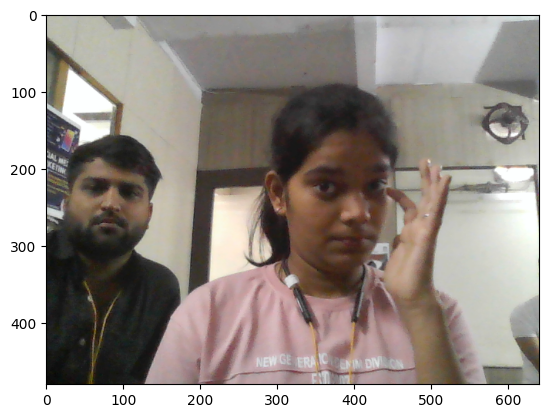

In [24]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# EXTRACRTION KEYPOINTS VALUES


In [25]:
results.pose_landmarks.landmark[0].visibility


0.9999949932098389

In [26]:
pose=[]
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [27]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face= np.array([[res.x, res.y, res.z, res.visibility] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [28]:
face= np.array([[res.x, res.y, res.z, res.visibility] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)

In [29]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    face= np.array([[res.x, res.y, res.z, res.visibility] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    lh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face,lh,rh])

In [30]:
extract_keypoints(results)[:-10]

array([ 0.61478239,  0.55612487, -0.67702848, ...,  0.        ,
        0.        ,  0.        ])

# setup folders for collection

In [31]:
# path for exported data, numpy array
DATA_PATH = os.path.join('MP_DATA')

# actions that we try to detect
actions = np.array(['hello','thanks','iloveyou'])

# thirty videos worth of data
no_sequences = 30

# videos are going to be 30 frames in length
sequence_length = 30 

In [32]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH,action,str(sequence)))
        except:
               pass 
              

# Collect keypoints values for training and testing

In [33]:
cap = cv2.VideoCapture(0)
# SET MEDIAPIPE MODEL
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Loop through actions
    for action in actions:
        # Loop through sequences aka vodeos
        for sequence in range(no_sequences):
            #Loop through videos length aka squence length
            for frame_num in range(sequence_length):

                # read feed
                ret, frame = cap.read()

                # MAKE DETECTIONS 
                image, results = mediapipe_detection(frame, holistic)
                print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)

                # Apply collections logic
                if frame_num == 0:
                    cv2.putText(image,'STARTING COLLECTION',(120,200),
                                cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),4,cv2.LINE_AA)
                    cv2.putText(image,'Collecting frames for{} video number{}'.format(action,sequence),(15,12),
                                cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image,'Collecting frames for{} video number{}'.format(action,sequence),(15,12),
                                cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                # New export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH,action,str(sequence), str(frame_num))
                np.save(npy_path,keypoints)

                # show to screen
                cv2.imshow('Opencv Feed', image)
    
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
cap.release()
cv2.destroyAllWindows()

    

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

# preprocess Data and createlabels anda features

In [34]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [35]:
label_map = {label:num for num, label in enumerate(actions)}

In [36]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [37]:
no_sequences

30

In [49]:
sequences, labels =[], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
             res= np.load(os.path.join(DATA_PATH,action,str(sequence),"{}.npy".format(frame_num)))
             window.append(res)
        sequences.append(window)
        labels.append(label_map[action])
        

                          


FileNotFoundError: [Errno 2] No such file or directory: 'MP_DATA\\hello\\20\\18.npy'

In [42]:
np.array(sequences).shape

(0,)

In [43]:
np.array(labels).shape

(0,)

In [44]:
x = np.array(sequences)

In [45]:
x.shape

(0,)

In [46]:
y = to_categorical(labels),type(int)

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
y

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.5)
#x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.5) 

In [ ]:
y_test.shape

# Build and train LSTM neural network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow_keras.layers import  LSTM, Dense
from tensorflow_keras.callbacks import TensorBoard


In [ ]:
log_dir = os.path.join('logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
model = Sequential()
model.add(LSTM(64,return_sequences=True,activation='relu',input_shape=(30,1662)))
model.add(LSTM(128,return_sequences=True,activation='relu'))
model.add(LSTM(64,return_sequences=False,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(action.shape[0],activation='softmax'))

In [ ]:
res = [.7,0.2,0.1]

In [ ]:
actions[np.argmax(res)]

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [ ]:
model.fit(x_train,y_train, epochs=200, callbacks=[tb_callback])

In [ ]:
model.summary()

# make predictions

In [ ]:
res = model.predict(x_test)

In [ ]:
actions[np.argmax(res[4])]

In [ ]:
actions[np.argmax(y_test[4])]

# Save weights

In [ ]:
model.save('actions.h5')

In [ ]:
del model

In [ ]:
model.load_weights('actions.h5')

# Evaluation using confusion matrix and accuracy

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix,accuracy_score

In [ ]:
yhat = model.predict(x_train)


In [ ]:
ytrue = np.argmax(y_train,axis=1).tolist()
yhat = np.argmax(yhat,axis=1).tolist()


In [ ]:
multilabel_confusion_matrix(ytrue,yhat)

In [ ]:
accuracy_score(ytrue,yhat)

# Test in real time

In [ ]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors [num], -1) 
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT HERSHEY SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
  
    return output_frame

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res,actions,image,colors))

In [ ]:
# 1. New detection variables 
sequence= []
sequence= []
predictions =[]
threshold = 0.4


cap = cv2.VideoCapture(0)
# SET MEDIAPIPE MODEL
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # MAKE DETECTIONS 
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.insert(0,keypoints)
        sequence-sequence[:30]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
        
        # viz logic
        if np.unique(predictions[-10:])[0]==np.argmax(res):
            if res[np.argmax(res)] > threshold:
                if len(sentence) > 0:
                   if actions[np.argmax(res)] != sentence[-1]:
                    sentence.append(actions[np.argmax(res)])
                else:
                      sentence.append(actions[np.argmax(res)])
                   
         
        if len(sentence) > 5:
            sentence = sentence[-5:]
        image = prob_viz(res,actions,image,colors)
        cv2.rectangle(image,(0,0),(640,40),(245,117,16),-1)
        cv2.putText(image,' '.join(sentence),(3,30),
                    cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
        cv2.imshow('Opencv Feed', image)
    
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()


In [ ]:
cap.release()
cv2.distroyAllwindows()

In [ ]:
res[np.argmax(res)] > threshold

In [ ]:
(num_sequences,30,1662)

In [ ]:
model.predict(np.expand_dims(x_test[0],axis=0))